##Introduction

Classification in deeplearning involves predicting whether a certain input image belongs to class. The classification of dataset could be **binary** which involves **yes/no** decision or it could be **multi-class** which is implemented in this notebook.
The objective of this notebook is to classify bees based on **subspecies**.
The Ground truth of the data set is mentioned in `bee_data.csv`.
Just like every Deeplearning Task ,this notebook has four steps:
* Preprocessing of DataSet
* Creating the Model
* Training
* Testing of the model

Import the necessary libraries required for the Task



In [8]:
import pandas as pd
import numpy as np
import os
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this section all the **Constants** are defined as shown below

In [5]:
IMAGE_PATH = '/content/drive/MyDrive/Project/bee_imgs/bee_imgs/'
CSV_FILE_PATH = '/content/drive/MyDrive/Project/bee_data.csv'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS = 50
PATIENCE = 5
VERBOSE = 1

### Preprocessing of DataSet
 1) Use `read_csv` from the `pandas`library to get the contents of `bee_data.csv`. Make some preliminary checks to see the total images and shape of csv file. Also check if every image name in `bee_id.csv` has an image in the image folder.

In [4]:
image_file_names = os.listdir(IMAGE_PATH)
print("Totals images {}".format(len(image_file_names)))
bee_csv_data = pd.read_csv(CSV_FILE_PATH)
print("Shape of csv file {}".format(bee_csv_data.shape))

#Check if all the names in csv file has corresponding image file
print("Images with file names in csv {}".format(len(set(bee_csv_data['file']).intersection(image_file_names))))

Totals images 5172
Shape of csv file (5172, 9)
Images with file names in csv 5172


2) Data set is genrally divided into `train` and `test` set to check the performance of the model after training . The ratio of the split is commanly **80:20**. 

The `train` set is further split to into `train` and `validation` set. This helps during training to improve the **weights-update**. 

The data is split and the number of images in each set is dispayed

In [9]:
#Create dataset train validation and test
train_data, test_data = train_test_split(bee_csv_data, 
                                         test_size=TEST_SIZE, 
                                         random_state=RANDOM_STATE, 
                                         stratify=bee_csv_data['subspecies']
                                         )

train_data, val_data = train_test_split(train_data, 
                                        test_size=VAL_SIZE, 
                                        random_state=RANDOM_STATE, 
                                        stratify=train_data['subspecies']
                                        )
print("Train set: {}".format(train_data.shape[0]))
print("Validate set: {}".format(val_data.shape[0]))
print("Test set: {}".format(test_data.shape[0]))

Train set: 3309
Validate set: 828
Test set: 1035


3) The total number of **Classes** is **7**. Hence the ground truth values has to be has to be customised a little for this task.

The `get_image` function is used to read the image, resize it and return the image as an array

The `categories_encoder` stack all the images using numpy and creats a the ground truth for each image using the `Pandas` - `get_dummies`. The returned **y** is of the shape`(total number of images, number of classes)` 

In [10]:
def get_image(file_name):
  image = skimage.io.imread(IMAGE_PATH+file_name)
  image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
  return image[:,:,:IMAGE_CHANNELS]

def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(get_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

X_train, Y_train = categories_encoder(train_data)
X_val, Y_val = categories_encoder(val_data)
X_test, Y_test = categories_encoder(test_data)

4) Dataset augmentation is a handy tool to feed in data by changing certain features to increase the number to data during training. Hence `ImageDataGenerator` with augmentation parameters as mentioned below is used.

In [11]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

### Creating the Model
The model consists of Sequential layers as stated below
* 1 convolution layer 16 filters
* 1 maxpooling layer
* 1 dropout layer
* 1 convolution layer 32 filters
* 1 droupout layer
* 1 flatten layer
* 1 dense output layer

In [14]:
def create_model(output, pretrained_weights=None):
  model = Sequential()
  model.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, 
                  input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                  activation='relu', padding='same'))
  model.add(MaxPool2D(MAX_POOL_DIM)) 
  model.add(Dropout(0.4))
  model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE,
                  activation='relu', padding='same'))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(output, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  if(pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

output = Y_train.columns.size
model = create_model(output)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 2

### Training
Before training it is a good practise to use some callback funtions to support the training process. Tensorflow supports several callback funtions and `LearningRateScheduler` `EarlyStopping` and `ModelCheckpoint`
are used here.

`LearningRateScheduler` is used to update the `learning_rate` as per the **`lambda`** function

In [11]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Project/best_model.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=False,
                                save_weights_only=True)

train_model  = model.fit_generator(image_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS,
                        validation_data=(X_val, Y_val),
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper, checkpointer, annealer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
103/103 [==============================] - 34s 320ms/step - loss: 1.2301 - accuracy: 0.6148 - val_loss: 0.7451 - val_accuracy: 0.7089

Epoch 00001: saving model to /content/drive/MyDrive/Project/best_model.h5
Epoch 2/50
103/103 [==============================] - 32s 311ms/step - loss: 0.6457 - accuracy: 0.7374 - val_loss: 0.5598 - val_accuracy: 0.7717

Epoch 00002: saving model to /content/drive/MyDrive/Project/best_model.h5
Epoch 3/50
103/103 [==============================] - 33s 322ms/step - loss: 0.5057 - accuracy: 0.8042 - val_loss: 0.5318 - val_accuracy: 0.7971

Epoch 00003: saving model to /content/drive/MyDrive/Project/best_model.h5
Epoch 4/50
103/103 [==============================] - 32s 310ms/step - loss: 0.4766 - accuracy: 0.8078 - val_loss: 0.5012 - val_accuracy: 0.8056

Epoch 00004: saving model to /content/drive/MyDrive/Project/best_model.h5
Epoch 5/50
103/103 [==============================] - 32s 309ms/step - loss: 0.4414 - accuracy: 0.8305 - val_loss: 0.434

### Testing
The history of the training is plotted and the performace of the model is tested on the defined **test set** `X_test` and `Y_test`


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


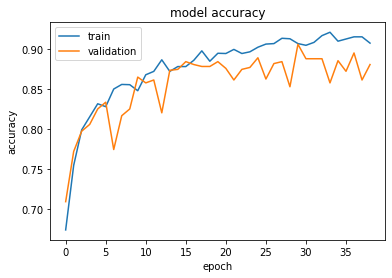

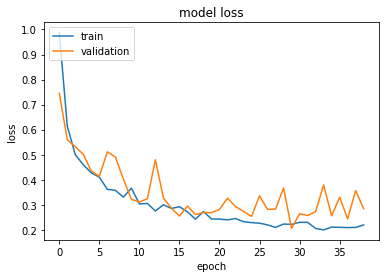

In [16]:
def plot_accuracy_and_loss(history):
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'], loc='upper left')
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','validation'], loc='upper left')
  plt.show()

plot_accuracy_and_loss(train_model.history)


In [15]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(Y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=Y_test.columns)) 
    test_res = model.evaluate(X_test, Y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

model = create_model(output, '/content/drive/MyDrive/Project/best_model.h5')
test = model.evaluate(X_test, Y_test, verbose=0)
test_accuracy_report(model)

                       precision    recall  f1-score   support

                   -1       0.97      0.79      0.87        86
1 Mixed local stock 2       0.52      0.89      0.66        94
  Carniolan honey bee       0.87      0.99      0.93       100
    Italian honey bee       0.96      0.85      0.90       602
    Russian honey bee       0.91      1.00      0.95       106
VSH Italian honey bee       1.00      0.82      0.90        40
    Western honey bee       1.00      1.00      1.00         7

             accuracy                           0.88      1035
            macro avg       0.89      0.91      0.89      1035
         weighted avg       0.91      0.88      0.89      1035

Loss function: 0.2791883051395416, accuracy: 0.8801932334899902
